In [84]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import neuraltda.topology2 as tp2
import neuraltda.simpComp as sc
import neuraltda.spectralAnalysis as sa
import pandas as pd
import h5py as h5
import pickle

import tqdm

import os
import datetime
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

# Class to define environments with holes
class TPEnv:
    
    def __init__(self, n_holes, hole_rad):
        self.xlim = [-1, 1]
        self.ylim = [-1, 1]
        self.holes = []
        self.hole_rad = hole_rad
        c = 0.75*(2*np.random.rand(2) - 1)
        for hole in range(n_holes):
            while self.hole_collide(c):
                c = 0.75*(2*np.random.rand(2) - 1)
            self.holes.append(c)
        #self.holes = 0.75*(2*np.random.rand(n_holes, 2) - 1) # keep centers in range -1, 1
        self.hole_rad = hole_rad # radius of holes
        
    def in_hole(self, x, y):
        '''
        Check to see if a point is in a hole
        '''
        for hole in self.holes:
            if np.linalg.norm(np.subtract([x, y], hole)) < self.hole_rad:
                return True
        return False
        
    def hole_collide(self, c):
        '''
        Check to see if a hole will collide with already existing holes 
        '''

        for h in self.holes:
            if np.sqrt((h[0] - c[0])**2 + (h[1] - c[1])**2) <= 2*self.hole_rad:
                return True
        return False
    
    
def generate_environments(N, h, numrepeats=1):
    envs = []
    for nholes in range(N):
        for r in range(numrepeats):
            envs.append(TPEnv(nholes, h))
    return envs

def convert_env_to_img(env,  NSQ):
    img = np.ones((NSQ, NSQ))
    X, Y = np.meshgrid(np.linspace(-1, 1, NSQ), np.linspace(-1, 1, NSQ))
    
    for hole in env.holes:
        hx = hole[0]
        hy = hole[1]
        diffx = X - hx*np.ones(np.shape(X))
        diffy = Y - hy*np.ones(np.shape(Y))
        dists = np.sqrt(np.power(diffx, 2) + np.power(diffy, 2))
        img[dists < env.hole_rad] = 0
        
    return img 

def compute_env_img_correlations(imgs):
    nsq, _ = np.shape(imgs[0])
    dat_mat = np.zeros((len(imgs), nsq*nsq))
    for ind,img in enumerate(imgs):
        dat_mat[ind, :] = img.flatten()
        
    cormat = np.corrcoef(dat_mat)
    return cormat
    

def generate_paths(space, n_steps, ntrials, dl):
    # pick a starting point
    final_pts = np.zeros((ntrials, n_steps, 2))
    for trial in range(ntrials):
        pts = []
        pt = (2*np.random.rand(1, 2) - 1)[0]
        while space.in_hole(pt[0], pt[1]):
            pt = (2*np.random.rand(1, 2) - 1)[0]
        #pts.append(pt)
        steps_to_go = n_steps
        while steps_to_go > 0:
            if steps_to_go % 10000 == 0:
                print("Steps to go: {}".format(steps_to_go))
            # pick a new point
            #theta = np.pi*np.random.rand(1)[0] - np.pi/2
            
            theta = 2*np.pi*np.random.rand(1)[0]
            dx = dl*np.cos(theta)
            dy = dl*np.sin(theta)

            if (abs(pt[0]+dx) < 1 and 
               abs(pt[1]+dy) < 1 and
                not space.in_hole(pt[0]+dx, pt[1]+dy)):
                
                steps_to_go -= 1

                pt[0] = pt[0] + dx
                pt[1] = pt[1] + dy
                pts.append(np.copy(pt))
        pts = np.vstack(pts)
        final_pts[trial, :, :] = pts
    return final_pts

def generate_place_fields_random(n_fields, rad):
    
    centers =2*np.random.rand(n_fields, 2) - 1
    return (centers, rad)

def generate_place_fields(n_fields, rad):
    
    nf = np.round(np.sqrt(n_fields))
    cx = np.linspace(-1, 1, nf)
    cy = np.linspace(-1, 1, nf)
    centers = np.array([np.array((x, y)) for x in cx for y in cy])
    rads = rad*np.ones(n_fields)
    return (centers, rads)

def generate_place_fields_perturbed_lattice(n_fields, rad, stddev=0.1):
    ''' generates place fields with centers normally perturbed around a lattice'''
    nf = np.round(np.sqrt(n_fields))
    cx = np.linspace(-1, 1, nf)
    cy = np.linspace(-1, 1, nf)
    cx = cx + stddev*np.random.randn(len(cx))
    cy = cy + stddev*np.random.randn(len(cy))
    centers = np.array([np.array((x, y)) for x in cx for y in cy])
    return (centers, rad)

def generate_place_fields_CI(n_fields, rad_range,exclusion_param):
    radii = (rad_range[1] - rad_range[0])*np.random.random_sample(n_fields) + rad_range[0]
    field_c = []
    for field in range(n_fields):
        #print('field = ', field)
        # pick a center in range -1, 1
        c = 2*np.random.rand(2) - 1
        if field == 0:
            field_c.append(c)
            continue
        added = False
        collision = False
        trie = 0
        maxtries = 100
        #print('field c', field_c)
        while trie < maxtries and added == False:
            #print('trie', trie)
            for cbar_ind, cbar in enumerate(field_c):
                #print('cbar', cbar)
                if np.linalg.norm(c-cbar) < exclusion_param*radii[cbar_ind]:
                    # already a field there, try again
                    #print('collision')
                    c = 2*np.random.rand(2) - 1
                    collision = True
                    break
            if collision:
                trie+=1
                collision = False
                continue
            else:
                field_c.append(c)
                added = True
        if not added:
            field_c.append(c)
    return (np.array(field_c), radii)
            
def generate_spikes_gaussian(paths, fields, max_rate, sigma):
    
    ncell, dim = fields.shape
    ntrial, nwin, _ = paths.shape
    
    spikes = np.zeros((ncell, nwin, ntrial))

    P1 = paths[:, :, np.newaxis, :]
    C1 = fields[np.newaxis, np.newaxis, :, :]

    P1 = np.tile(P1, [1, 1, ncell, 1])
    C1 = np.tile(C1, [ntrial, nwin, 1, 1])

    S = P1 - C1
    M = np.einsum('ijkl, ijkl->ijk', S, S)
    probs = max_rate*np.exp(-1*M / (2*sigma**2))
    spikes = 1*np.greater(probs, np.random.random(np.shape(probs)))
    return np.einsum('ijk->kji', spikes)

def generate_spikes(paths, fields, max_rate, rads):
    
    ncell, dim = fields.shape
    ntrial, nwin, _ = paths.shape
    
    spikes = np.zeros((ncell, nwin, ntrial))

    P1 = paths[:, :, np.newaxis, :]
    C1 = fields[np.newaxis, np.newaxis, :, :]

    P1 = np.tile(P1, [1, 1, ncell, 1])
    C1 = np.tile(C1, [ntrial, nwin, 1, 1])

    S = P1 - C1
    M = np.einsum('ijkl, ijkl->ijk', S, S)
    #SIGMA = sigma*np.ones(M.shape)
    SIGMA = np.tile(rads[np.newaxis, np.newaxis, :], (ntrial, nwin, 1))
    # if distance is less than sigma, then p = max_rate
    probs = max_rate*np.less(M, SIGMA)
    spikes = 1*np.greater(probs, np.random.random(np.shape(probs)))
    return np.einsum('ijk->kji', spikes)

def spikes_to_dataframe(spikes, fs, nsecs):
    (ncells, nwin, ntrial) = spikes.shape
    spikes_frame = pd.DataFrame(columns=['cluster', 'time_samples', 'recording'])
    trials_frame = pd.DataFrame(columns=['stimulus', 'time_samples', 'stimulus_end'])
    for trial in range(ntrial):
        for cell in range(ncells):
            cellspikes = np.nonzero(spikes[cell, :, trial])[0] + trial*(nsecs+2)*fs
            celldict = {'cluster': len(cellspikes)*[cell], 'time_samples': cellspikes, 'recording': len(cellspikes)*[0]}
            cellframe = pd.DataFrame(celldict)
            spikes_frame = spikes_frame.append(cellframe, ignore_index=True)
        trial_frame = pd.DataFrame({'stimulus': 'joe', 'time_samples': trial*(nsecs+2)*fs, 'stimulus_end': (trial*(nsecs+2) + nsecs)*fs, 'recording': 0}, index=[0])
        trials_frame = trials_frame.append(trial_frame, ignore_index=True)
    clusters_frame = pd.DataFrame({'cluster': range(ncells), 'quality': ncells*['Good']})
    return (spikes_frame.sort_values(by='time_samples'), trials_frame, clusters_frame)

def mu_k(k, Ncells):
    return 1 - np.pi*np.sqrt(float(k-1)/float(Ncells))

def add_cellgroups(graph, cg, Ncells, depth):
    # for each neighbor:
    #print(depth)
    cg_orig = tuple(cg)
    cg_list = list(cg)
    if len(cg_list) <= 1:
#         print(cg)
#         print('base case')
        return
    k = len(cg) - 1
    muk = mu_k(k, Ncells)
    for ind in range(len(cg)):
        a = cg_list.pop(ind)
#         if (len(cg) <= 2):
#             print(cg_list, cg_orig)
        graph.add_edge(tuple(cg_list), cg_orig, weight=muk)
        add_cellgroups(graph, cg_list, Ncells, depth+1)
        cg_list.insert(ind, a)
    return

def stimspacegraph_nx(maxsimps, Ncells):
    g = nx.Graph()
    depth = 0
    for maxsimp in maxsimps:
        add_cellgroups(g, maxsimp, Ncells, depth)
    return g

def plot_environment(env, fields, sigma):
    # Plot environments
    plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')

    rad = sigma

    fig = plt.figure()
    # plt.plot(pths1[0, :, 0], pths1[0, :, 1], alpha=0.5)
    ax = fig.add_subplot(111)
    #ax = plt.gca()
    for hole in env.holes:

        h1 = plt.Circle(hole, env.hole_rad, fill=False, color='r', )
        ax.add_artist(h1)
    for field in fields:
        h2 = plt.Circle(field, rad, fill=True, color='g', alpha=0.15)
        ax.add_artist(h2)
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    ax.set_xticks([])
    ax.set_yticks([])
    #plt.title('Environment 1')
    ax.set_aspect('equal')


/home/brad/DailyLog/20180323/


In [122]:
L = 2 # meter
vel = 0.1*L # meters / second

hole_rad = 0.3
nsecs = 10*60
fs = 10
nwin = nsecs*fs
ncells = 90

dl = vel/fs
dl = vel/1
ntrials = 1

max_rate_hz = 2 # spikes/ second
max_rate_phys = fs # spikes / second
max_rate = max_rate_hz / max_rate_phys
sigma = 0.075*L

beta = -1.0
dim = 1

max_hole = 6
nrepeats = 1
num_envs = max_hole*nrepeats 
exclusion_param = 1.2 # how far away centers of pfs must be as a multiple of hole radius. 

NSQ = 100

windt = 100.0
thresh = 6.0
period = [0,0]
dtovr = 5.0

# Generate environments
print('Generating environments...')
envs = generate_environments(max_hole, hole_rad, nrepeats)

# Generate images
print('Generating images...')
imgs = []
for env in envs:
    imgs.append(convert_env_to_img(env, NSQ))

# compute environment correlations
print('Computing environment correlations...')
corrmat = compute_env_img_correlations(imgs)

# Run Simulations
print('Generating placefields...')
(fields, rads) = generate_place_fields_CI(ncells, [sigma, sigma], exclusion_param)

spikes = []

print('Generating spikes...')
for env1 in envs:

    pths1 = generate_paths(env1, nwin, ntrials, dl)  # 10 walks through environment 1
    spikes1 = generate_spikes(pths1, fields, max_rate, rads)
    spikes.append(spikes1)


# Bin Data
graphs = []  # storing simplicial complexes for each environment
SCGs_trials = []
for ind, spikes1 in enumerate(spikes):
    print('Binning data...')
    E1s = []  # storing simplicial complexes for each trial for an environment
    tspikes, ttrials, tclust = spikes_to_dataframe(spikes1, fs=fs, nsecs=nsecs)
    tp2.build_binned_file_quick(tspikes, ttrials, tclust, windt, fs, ['Good'], period, '/home/brad/pcsim/placecellsimdat-stimspace{}.binned'.format(ind), dt_overlap=dtovr)

# compute simplicial complexes
    print('Computing simplicial complexes...')
    with h5.File('/home/brad/pcsim/placecellsimdat-stimspace{}.binned'.format(ind), 'r') as bf:
        poptens = np.array(bf['joe']['pop_tens'])
        ncell, nwin, ntrial = poptens.shape
        for trial in range(ntrial):
            binmat = sc.binnedtobinary(poptens[:, :, trial], thresh)
            print(np.amax(np.sum(binmat, axis = 0)))
            maxsimps = sc.binarytomaxsimplex(binmat, rDup=True)
            print(maxsimps)
            g = stimspacegraph_nx(maxsimps, ncells)
    graphs.append(g)

Generating environments...
Generating images...
Computing environment correlations...
Generating placefields...


/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Generating spikes...
Binning data...
Computing simplicial complexes...
7
[(), (0,), (1,), (2,), (0, 2), (3,), (4,), (0, 4), (2, 4), (5,), (2, 5), (6,), (7,), (8,), (1, 8), (9,), (0, 9), (2, 9), (4, 9), (10,), (3, 10), (7, 10), (11,), (12,), (7, 12), (13,), (0, 13), (2, 13), (4, 13), (0, 4, 13), (12, 13), (14,), (15,), (6, 15), (16,), (8, 16), (14, 16), (15, 16), (17,), (8, 17), (14, 17), (15, 17), (16, 17), (14, 16, 17), (18,), (2, 18), (4, 18), (13, 18), (0, 13, 18), (4, 13, 18), (19,), (5, 19), (6, 19), (9, 19), (5, 9, 19), (15, 19), (6, 15, 19), (20,), (1, 20), (8, 20), (21,), (1, 21), (8, 21), (14, 21), (16, 21), (17, 21), (14, 17, 21), (20, 21), (22,), (3, 22), (7, 22), (10, 22), (3, 10, 22), (3, 7, 10, 22), (23,), (0, 23), (5, 23), (6, 23), (9, 23), (0, 9, 23), (15, 23), (19, 23), (24,), (7, 24), (10, 24), (12, 24), (25,), (0, 25), (9, 25), (14, 25), (23, 25), (2, 23, 25), (9, 23, 25), (24, 25), (26,), (4, 26), (10, 26), (7, 10, 26), (12, 26), (13, 26), (4, 13, 26), (18, 26), (24

Binning data...
Computing simplicial complexes...
8
[(), (0,), (1,), (2,), (0, 2), (3,), (4,), (0, 4), (2, 4), (0, 2, 4), (5,), (6,), (5, 6), (7,), (3, 7), (8,), (1, 8), (9,), (0, 9), (2, 9), (0, 2, 9), (4, 9), (5, 9), (10,), (3, 10), (7, 10), (3, 7, 10), (11,), (12,), (7, 12), (10, 12), (13,), (0, 13), (4, 13), (2, 4, 13), (14,), (15,), (6, 15), (16,), (8, 16), (14, 16), (15, 16), (17,), (8, 17), (15, 17), (16, 17), (14, 16, 17), (18,), (13, 18), (4, 13, 18), (20,), (1, 20), (8, 20), (21,), (1, 21), (14, 21), (16, 21), (17, 21), (20, 21), (1, 20, 21), (8, 20, 21), (22,), (3, 22), (10, 22), (7, 10, 22), (23,), (0, 23), (2, 23), (0, 2, 23), (5, 23), (5, 6, 23), (9, 23), (5, 9, 23), (24,), (7, 24), (12, 24), (10, 12, 24), (25,), (0, 25), (2, 25), (23, 25), (5, 23, 25), (26,), (0, 26), (12, 26), (10, 12, 26), (13, 26), (18, 26), (0, 18, 26), (24, 26), (12, 24, 26), (27,), (3, 27), (7, 27), (10, 27), (11, 27), (24, 27), (28,), (3, 28), (11, 28), (27, 28), (29,), (14, 29), (16, 29), (17, 29

Binning data...
Computing simplicial complexes...
8
[(), (0,), (1,), (2,), (3,), (4,), (0, 4), (5,), (6,), (5, 6), (7,), (3, 7), (8,), (1, 8), (9,), (5, 9), (6, 9), (10,), (3, 10), (7, 10), (11,), (12,), (10, 12), (7, 10, 12), (13,), (2, 13), (14,), (8, 14), (15,), (5, 15), (6, 15), (16,), (6, 16), (8, 16), (14, 16), (15, 16), (17,), (1, 17), (8, 17), (14, 17), (8, 14, 17), (15, 17), (16, 17), (8, 16, 17), (18,), (19,), (5, 19), (6, 19), (9, 19), (15, 19), (6, 15, 19), (20,), (1, 20), (8, 20), (17, 20), (21,), (1, 21), (8, 21), (11, 21), (14, 21), (17, 21), (8, 17, 21), (20, 21), (22,), (3, 22), (3, 7, 22), (10, 22), (7, 10, 22), (23,), (5, 23), (6, 23), (6, 9, 23), (19, 23), (5, 15, 19, 23), (24,), (25,), (9, 25), (14, 25), (26,), (12, 26), (13, 26), (18, 26), (27,), (3, 27), (3, 10, 27), (11, 27), (28,), (3, 28), (11, 28), (27, 28), (29,), (14, 29), (15, 29), (16, 29), (17, 29), (14, 17, 29), (17, 21, 29), (25, 29), (30,), (8, 30), (14, 30), (15, 30), (16, 30), (14, 16, 30), (17, 30)

Binning data...
Computing simplicial complexes...
8
[(), (0,), (1,), (2,), (0, 2), (3,), (4,), (0, 4), (2, 4), (5,), (2, 5), (6,), (5, 6), (7,), (3, 7), (8,), (9,), (0, 9), (10,), (3, 10), (7, 10), (3, 7, 10), (11,), (3, 11), (12,), (10, 12), (13,), (0, 13), (2, 13), (4, 13), (12, 13), (14,), (11, 14), (15,), (16,), (8, 16), (14, 16), (17,), (8, 17), (14, 17), (15, 17), (16, 17), (14, 16, 17), (15, 16, 17), (18,), (0, 18), (2, 18), (4, 18), (0, 4, 18), (13, 18), (0, 13, 18), (4, 13, 18), (19,), (6, 19), (15, 19), (6, 15, 19), (20,), (1, 20), (21,), (11, 21), (14, 21), (22,), (3, 22), (10, 22), (23,), (0, 23), (2, 23), (0, 2, 23), (5, 23), (19, 23), (24,), (10, 24), (7, 10, 24), (12, 24), (25,), (0, 25), (2, 25), (0, 2, 25), (9, 25), (0, 9, 25), (14, 25), (9, 23, 25), (26,), (4, 26), (0, 4, 26), (10, 26), (12, 26), (10, 12, 26), (13, 26), (24, 26), (27,), (3, 27), (7, 27), (10, 27), (11, 27), (22, 27), (24, 27), (7, 24, 27), (28,), (3, 28), (11, 28), (22, 28), (3, 22, 28), (27, 28), (3,

Binning data...
Computing simplicial complexes...
7
[(), (0,), (1,), (2,), (0, 2), (3,), (4,), (0, 2, 4), (5,), (6,), (5, 6), (7,), (8,), (1, 8), (9,), (0, 9), (5, 9), (2, 5, 9), (10,), (7, 10), (3, 7, 10), (11,), (1, 11), (12,), (13,), (12, 13), (14,), (15,), (6, 15), (16,), (8, 16), (15, 16), (17,), (15, 17), (16, 17), (18,), (4, 18), (13, 18), (4, 13, 18), (19,), (20,), (8, 20), (1, 8, 20), (21,), (1, 21), (8, 21), (14, 21), (8, 17, 21), (20, 21), (22,), (3, 22), (7, 22), (3, 7, 22), (10, 22), (23,), (0, 23), (2, 23), (0, 2, 23), (2, 5, 9, 23), (24,), (10, 24), (12, 24), (25,), (0, 25), (9, 25), (0, 9, 25), (14, 25), (23, 25), (24, 25), (26,), (10, 26), (12, 26), (18, 26), (24, 26), (12, 24, 26), (27,), (3, 27), (7, 27), (11, 27), (14, 27), (24, 27), (28,), (3, 28), (11, 28), (27, 28), (29,), (9, 29), (14, 29), (15, 29), (16, 29), (25, 29), (30,), (14, 30), (15, 30), (16, 30), (17, 30), (29, 30), (14, 29, 30), (16, 29, 30), (17, 29, 30), (31,), (6, 31), (9, 31), (15, 31), (16, 31), 

Binning data...
Computing simplicial complexes...
7
[(), (0,), (1,), (2,), (0, 2), (3,), (4,), (0, 4), (2, 4), (0, 2, 4), (5,), (6,), (5, 6), (7,), (8,), (1, 8), (9,), (4, 9), (5, 9), (10,), (7, 10), (11,), (1, 11), (3, 11), (12,), (10, 12), (13,), (0, 13), (0, 2, 13), (4, 13), (0, 4, 13), (12, 13), (14,), (11, 14), (15,), (16,), (8, 16), (14, 16), (15, 16), (17,), (8, 17), (14, 17), (16, 17), (18,), (0, 18), (2, 18), (4, 18), (0, 4, 18), (13, 18), (19,), (5, 19), (6, 19), (5, 6, 19), (9, 19), (15, 19), (20,), (1, 20), (8, 20), (21,), (1, 21), (8, 21), (14, 21), (20, 21), (22,), (23,), (0, 23), (0, 2, 23), (5, 23), (0, 5, 23), (9, 23), (5, 9, 23), (19, 23), (24,), (7, 24), (10, 24), (13, 24), (25,), (14, 25), (26,), (0, 26), (0, 4, 26), (10, 26), (12, 26), (13, 26), (18, 26), (4, 18, 26), (7, 24, 26), (0, 25, 26), (27,), (3, 27), (28,), (3, 28), (11, 28), (27, 28), (29,), (14, 29), (15, 29), (16, 29), (17, 29), (16, 17, 29), (30,), (14, 30), (15, 30), (16, 30), (14, 16, 30), (17, 30), 

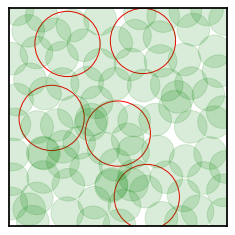

In [123]:
plot_environment(envs[-1], fields, sigma)

In [113]:
len(fields)

120

In [125]:
g = graphs[-1]
nx.info(g)

'Name: \nType: Graph\nNumber of nodes: 4643\nNumber of edges: 14732\nAverage degree:   6.3459'

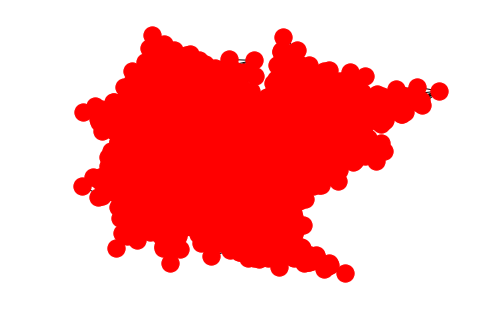

In [126]:
g = graphs[-2]
nx.info(g)
dg = nx.number_of_nodes(g)
dmat = np.zeros((dg, dg))

dmat = nx.floyd_warshall_numpy(g)
# for ind1, n1 in enumerate(nx.nodes(g)):
#     for ind2, n2 in enumerate(nx.nodes(g)):
#         dmat[ind1, ind2] = nx.shortest_path_length(g, source=(1,7,12), target=(14, 18, 22), weight='weight')

In [76]:
from sklearn.manifold import MDS

In [127]:
gmds = MDS(n_jobs=-2, dissimilarity='precomputed')
embed_pts = gmds.fit_transform(dmat)

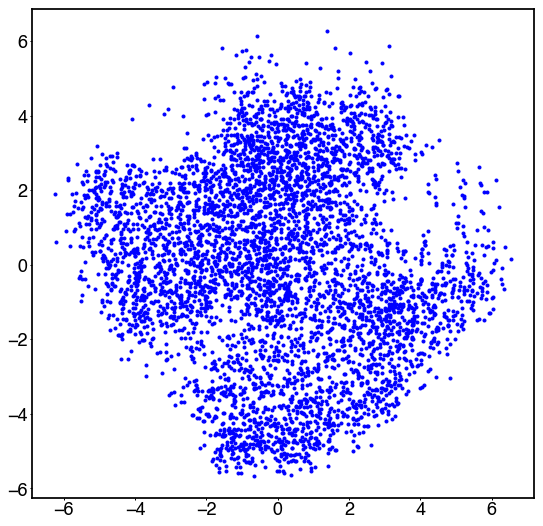

In [128]:
fig = plt.figure(figsize=(9,9))
plt.plot(embed_pts[:, 0], embed_pts[:, 1], 'b.')

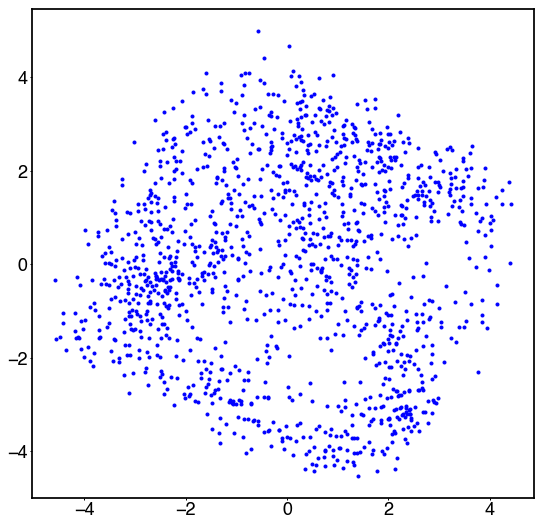

In [95]:
fig = plt.figure(figsize=(9,9))
plt.plot(embed_pts[:, 0], embed_pts[:, 1], 'b.')

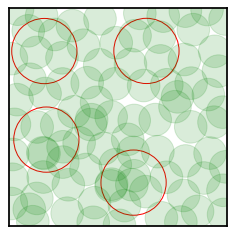

In [130]:
plot_environment(envs[-2], fields, sigma)